# making dataset ready

In [12]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.2 MB/s eta 0:00:00


In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.8 MB/s eta 0:00:00


In [2]:
!pip install wordcloud


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from contractions import contractions_dict
import contractions
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc  # For evaluation metrics
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# nlp models

In [2]:
# Load Data
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")


In [3]:
# Inspect the data
print(train_df['cleaned_tweet'].head())
print(val_df['cleaned_tweet'].head())
print(test_df['cleaned_tweet'].head())

# Check for missing values
print(train_df['cleaned_tweet'].isnull().sum())
print(val_df['cleaned_tweet'].isnull().sum())
print(test_df['cleaned_tweet'].isnull().sum())

# Drop rows with missing values in 'cleaned_tweet'
train_df = train_df.dropna(subset=['cleaned_tweet'])
val_df = val_df.dropna(subset=['cleaned_tweet'])
test_df = test_df.dropna(subset=['cleaned_tweet'])

0    charlie jacobs got confused about the ice buck...
1    she playin pussy hole bingo she drawing the ne...
2    i be telling mcgirt music aint enoughyou got t...
3    i aint to show bout dem colored diamonds you t...
4    yall claim you want a good amp loyal girl but ...
Name: cleaned_tweet, dtype: object
0                       hoe about to bust ha knee caps
1    i know i talk a lot of shit but bitch best bel...
2                   all people do in my house is bitch
3                       i got my eyes on this red bone
4    i gota hand fulla brothers trek gang bitch we ...
Name: cleaned_tweet, dtype: object
0    confusing circumstances seem to get in the way...
1    psa big booty hoe with tig ol bitties xbox one...
2    maybe i shoulda informed my cousin of my socia...
3    why the fuck are the throwing batting practice...
4                     you just want some attention hoe
Name: cleaned_tweet, dtype: object
1
0
1


# new model

## bert

In [6]:
import numpy as np
import pandas as pd
import os, re
import torch
import tensorflow as tf
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time
import datetime
import random
from tqdm import tqdm  # Add tqdm for progress bars

# Load Data
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

# Check GPU availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Convert all entries in the 'preprocessed_tweet' column to strings
train_df['preprocessed_tweet'] = train_df['preprocessed_tweet'].astype(str)
val_df['preprocessed_tweet'] = val_df['preprocessed_tweet'].astype(str)
test_df['preprocessed_tweet'] = test_df['preprocessed_tweet'].astype(str)

# Preprocessing
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split())

# Clean tweets
train_df['preprocessed_tweet'] = train_df['preprocessed_tweet'].apply(strip_all_entities)
val_df['preprocessed_tweet'] = val_df['preprocessed_tweet'].apply(strip_all_entities)
test_df['preprocessed_tweet'] = test_df['preprocessed_tweet'].apply(strip_all_entities)

# Get the lists of sentences and their labels
trn_sentences = train_df['preprocessed_tweet'].values
train_labels = train_df['label'].values

val_sentences = val_df['preprocessed_tweet'].values
validation_labels = val_df['label'].values

tst_sentences = test_df['preprocessed_tweet'].values
test_labels = test_df['label'].values

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        padding='max_length',
                                        truncation=True,
                                        return_attention_mask=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 128
train_inputs, train_masks = bert_encode(trn_sentences, MAX_LEN)
validation_inputs, validation_masks = bert_encode(val_sentences, MAX_LEN)
test_inputs, test_masks = bert_encode(tst_sentences, MAX_LEN)

# Convert data to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Create DataLoader
batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=2e-5,
                              eps=1e-8)

# Scheduler
epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Helper functions
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0
    total_eval_loss = 0

    for batch in tqdm(validation_dataloader, desc="Validating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': format_time(time.time() - t0)
        }
    )

print("")
print("Training complete!")

# Convert statistics to a DataFrame for plotting
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Plot the training and validation loss over epochs.
plt.figure(figsize=(12, 6))
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs.
plt.figure(figsize=(12, 6))
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:12<00:00,  1.15s/it]



  Average training loss: 0.34
  Training epoch took: 0:05:12

Running Validation...


Validating: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


  Accuracy: 0.90
  Validation took: 0:00:24

======== Epoch 2 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:19<00:00,  1.17s/it]



  Average training loss: 0.23
  Training epoch took: 0:05:19

Running Validation...


Validating: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]


  Accuracy: 0.91
  Validation took: 0:00:24

======== Epoch 3 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:19<00:00,  1.17s/it]



  Average training loss: 0.19
  Training epoch took: 0:05:19

Running Validation...


Validating: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


  Accuracy: 0.91
  Validation took: 0:00:24

======== Epoch 4 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:19<00:00,  1.18s/it]



  Average training loss: 0.17
  Training epoch took: 0:05:20

Running Validation...


Validating: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]

  Accuracy: 0.91
  Validation took: 0:00:24

Training complete!


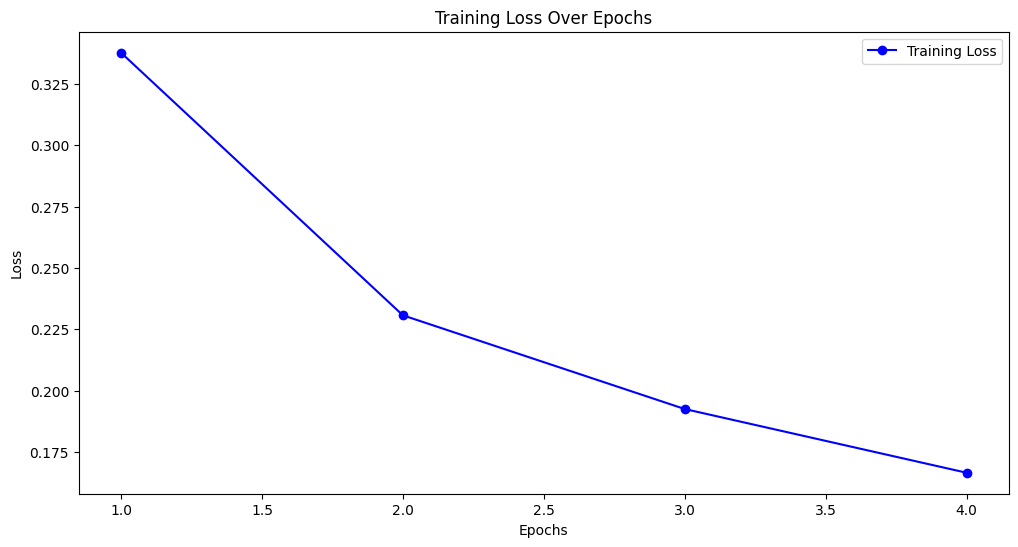

In [9]:
# After training is complete, plot the values
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), loss_values, 'b-o', label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Running Test...


Testing: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


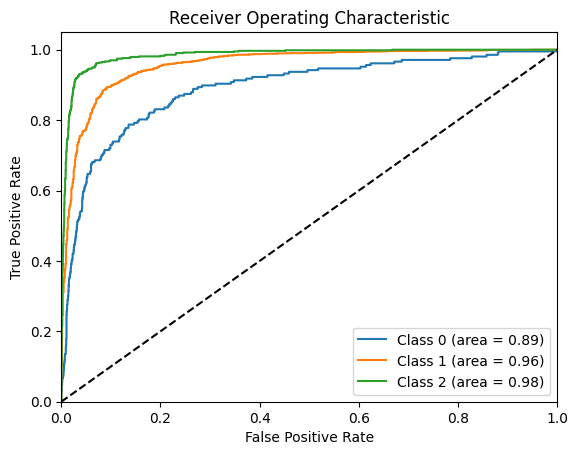

Accuracy: 0.91
F1-score: 0.91
Recall: 0.91
Precision: 0.90
Confusion Matrix:
[[  80  117   10]
 [  65 2759   56]
 [  17   71  543]]


In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc  # For evaluation metrics

# Evaluation on test set
print("Running Test...")

model.eval()
test_accuracy = 0
nb_test_steps = 0
test_preds = []
test_labels = []

for batch in tqdm(test_dataloader, desc="Testing"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    test_preds.extend(logits)
    test_labels.extend(label_ids)

# Calculate metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

test_pred_labels = np.argmax(test_preds, axis=1)

accuracy = accuracy_score(test_labels, test_pred_labels)
f1 = f1_score(test_labels, test_pred_labels, average='weighted')
recall = recall_score(test_labels, test_pred_labels, average='weighted')
precision = precision_score(test_labels, test_pred_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# ROC-AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

### bertweet

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...



Training: 100%|██████████| 272/272 [05:23<00:00,  1.19s/it]



  Average training loss: 0.36
  Training epoch took: 0:05:24

Running Validation...



Validating: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s]


  Accuracy: 0.91
  Validation took: 0:00:23

======== Epoch 2 / 4 ========
Training...



Training: 100%|██████████| 272/272 [05:22<00:00,  1.19s/it]



  Average training loss: 0.23
  Training epoch took: 0:05:23

Running Validation...



Validating: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s]


  Accuracy: 0.92
  Validation took: 0:00:23

======== Epoch 3 / 4 ========
Training...



Training: 100%|██████████| 272/272 [05:23<00:00,  1.19s/it]



  Average training loss: 0.20
  Training epoch took: 0:05:23

Running Validation...



Validating: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s]


  Accuracy: 0.92
  Validation took: 0:00:23

======== Epoch 4 / 4 ========
Training...



Training: 100%|██████████| 272/272 [05:23<00:00,  1.19s/it]



  Average training loss: 0.18
  Training epoch took: 0:05:23

Running Validation...



Validating: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s]


  Accuracy: 0.91
  Validation took: 0:00:23

Training complete!


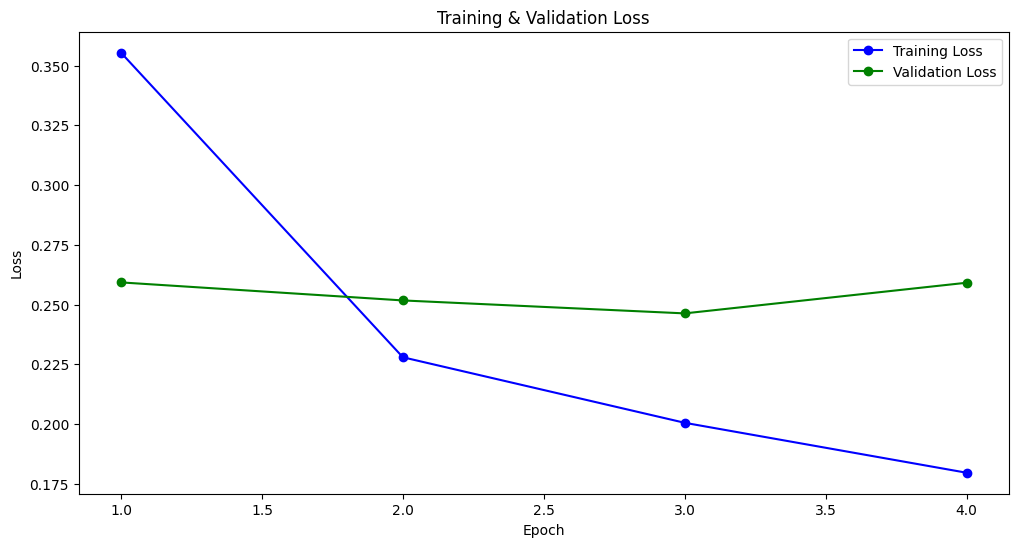

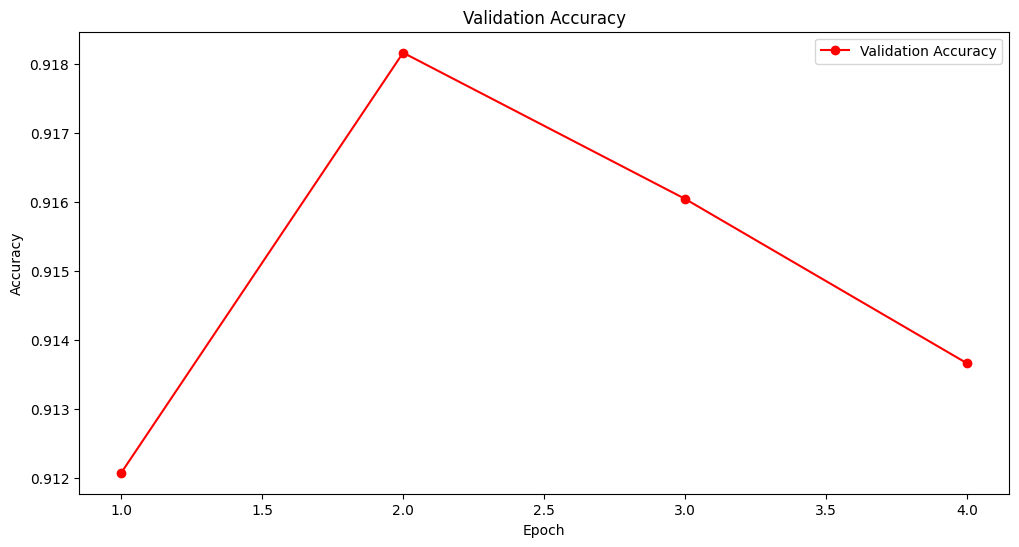

In [14]:
import numpy as np
import pandas as pd
import os, re
import torch
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time
import datetime
import random
from tqdm import tqdm  # Add tqdm for progress bars

# Load Data
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

# Check GPU availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Convert all entries in the 'preprocessed_tweet' column to strings
train_df['preprocessed_tweet'] = train_df['preprocessed_tweet'].astype(str)
val_df['preprocessed_tweet'] = val_df['preprocessed_tweet'].astype(str)
test_df['preprocessed_tweet'] = test_df['preprocessed_tweet'].astype(str)

# Preprocessing
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split())

# Clean tweets
train_df['preprocessed_tweet'] = train_df['preprocessed_tweet'].apply(strip_all_entities)
val_df['preprocessed_tweet'] = val_df['preprocessed_tweet'].apply(strip_all_entities)
test_df['preprocessed_tweet'] = test_df['preprocessed_tweet'].apply(strip_all_entities)

# Get the lists of sentences and their labels
trn_sentences = train_df['preprocessed_tweet'].values
train_labels = train_df['label'].values

val_sentences = val_df['preprocessed_tweet'].values
validation_labels = val_df['label'].values

tst_sentences = test_df['preprocessed_tweet'].values
test_labels = test_df['label'].values

# Tokenization
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)

def bertweet_encode(data, max_len):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        padding='max_length',
                                        truncation=True,
                                        return_attention_mask=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 128
train_inputs, train_masks = bertweet_encode(trn_sentences, MAX_LEN)
validation_inputs, validation_masks = bertweet_encode(val_sentences, MAX_LEN)
test_inputs, test_masks = bertweet_encode(tst_sentences, MAX_LEN)

# Convert data to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Create DataLoader
batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Load BERTweet model
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=2e-5,
                              eps=1e-8)

# Scheduler
epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Helper functions
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0
    total_eval_loss = 0

    for batch in tqdm(validation_dataloader, desc="Validating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': format_time(time.time() - t0)
        }
    )

print("")
print("Training complete!")

# Convert statistics to a DataFrame for plotting
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Plot the training and validation loss over epochs.
plt.figure(figsize=(12, 6))
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs.
plt.figure(figsize=(12, 6))
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Running Test...



Testing: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s]


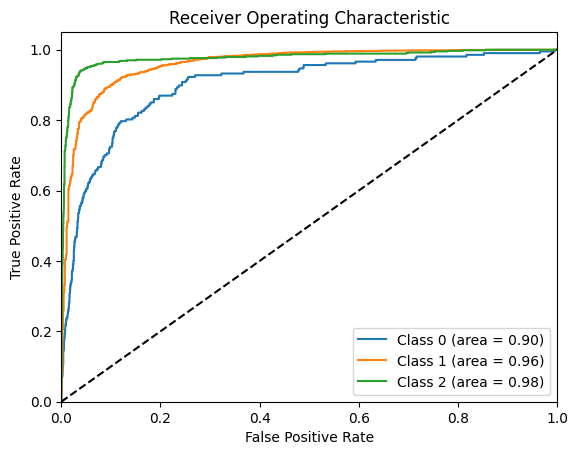

Accuracy: 0.91
F1-score: 0.91
Recall: 0.91
Precision: 0.91
Confusion Matrix:
[[  94  104    9]
 [  84 2737   59]
 [  14   62  555]]


In [15]:
# Evaluation on test set
print("Running Test...")

model.eval()
test_accuracy = 0
nb_test_steps = 0
test_preds = []
test_labels = []

for batch in tqdm(test_dataloader, desc="Testing"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    test_preds.extend(logits)
    test_labels.extend(label_ids)

# Calculate metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

test_pred_labels = np.argmax(test_preds, axis=1)

accuracy = accuracy_score(test_labels, test_pred_labels)
f1 = f1_score(test_labels, test_pred_labels, average='weighted')
recall = recall_score(test_labels, test_pred_labels, average='weighted')
precision = precision_score(test_labels, test_pred_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# ROC-AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

### roberta

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:24<00:00,  1.19s/it]



  Average training loss: 0.37
  Training epoch took: 0:05:24

Running Validation...


Validating: 100%|██████████| 59/59 [00:22<00:00,  2.58it/s]


  Accuracy: 0.90
  Validation took: 0:00:23

======== Epoch 2 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:23<00:00,  1.19s/it]



  Average training loss: 0.25
  Training epoch took: 0:05:24

Running Validation...


Validating: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s]


  Accuracy: 0.91
  Validation took: 0:00:23

======== Epoch 3 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:23<00:00,  1.19s/it]



  Average training loss: 0.21
  Training epoch took: 0:05:24

Running Validation...


Validating: 100%|██████████| 59/59 [00:22<00:00,  2.57it/s]


  Accuracy: 0.91
  Validation took: 0:00:23

======== Epoch 4 / 4 ========
Training...


Training: 100%|██████████| 272/272 [05:23<00:00,  1.19s/it]



  Average training loss: 0.19
  Training epoch took: 0:05:24

Running Validation...


Validating: 100%|██████████| 59/59 [00:23<00:00,  2.56it/s]


  Accuracy: 0.91
  Validation took: 0:00:23

Training complete!


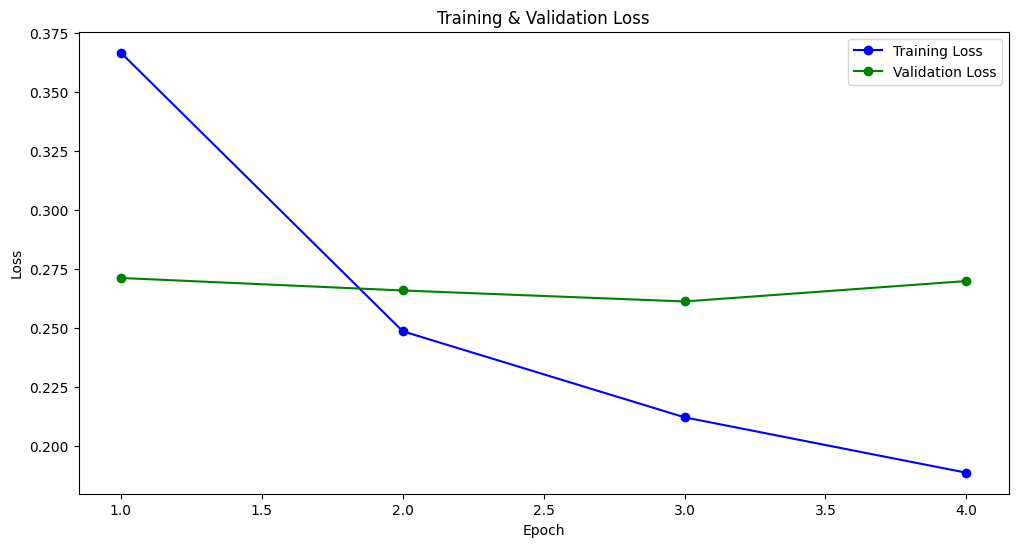

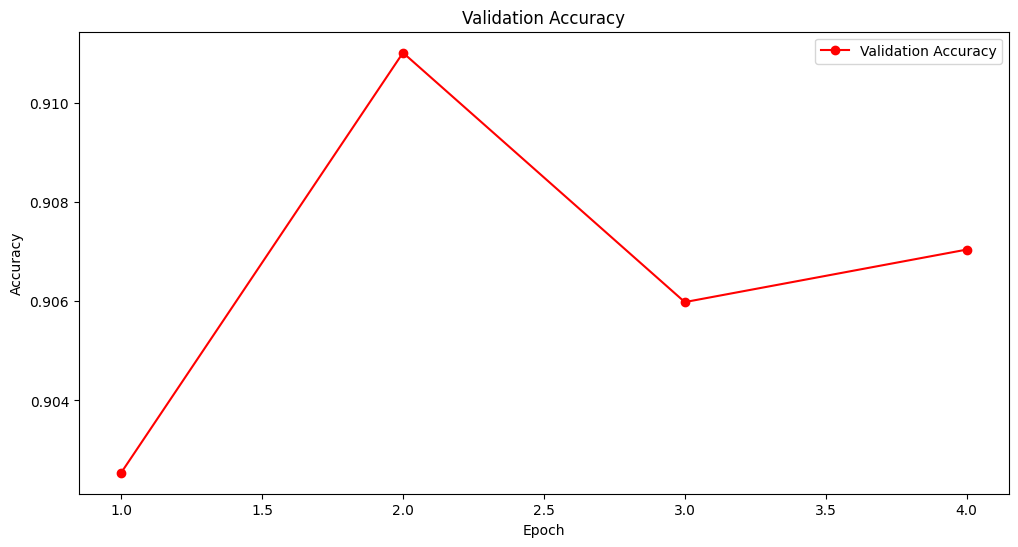

In [4]:
import numpy as np
import pandas as pd
import os, re
import torch
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time
import datetime
import random
from tqdm import tqdm  # Add tqdm for progress bars

# Load Data
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

# Check GPU availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Convert all entries in the 'preprocessed_tweet' column to strings
train_df['preprocessed_tweet'] = train_df['preprocessed_tweet'].astype(str)
val_df['preprocessed_tweet'] = val_df['preprocessed_tweet'].astype(str)
test_df['preprocessed_tweet'] = test_df['preprocessed_tweet'].astype(str)

# Preprocessing
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split())

# Clean tweets
train_df['preprocessed_tweet'] = train_df['preprocessed_tweet'].apply(strip_all_entities)
val_df['preprocessed_tweet'] = val_df['preprocessed_tweet'].apply(strip_all_entities)
test_df['preprocessed_tweet'] = test_df['preprocessed_tweet'].apply(strip_all_entities)

# Get the lists of sentences and their labels
trn_sentences = train_df['preprocessed_tweet'].values
train_labels = train_df['label'].values

val_sentences = val_df['preprocessed_tweet'].values
validation_labels = val_df['label'].values

tst_sentences = test_df['preprocessed_tweet'].values
test_labels = test_df['label'].values

# Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def roberta_encode(data, max_len):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        padding='max_length',
                                        truncation=True,
                                        return_attention_mask=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

MAX_LEN = 128
train_inputs, train_masks = roberta_encode(trn_sentences, MAX_LEN)
validation_inputs, validation_masks = roberta_encode(val_sentences, MAX_LEN)
test_inputs, test_masks = roberta_encode(tst_sentences, MAX_LEN)

# Convert data to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

# Create DataLoader
batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=2e-5,
                              eps=1e-8)

# Scheduler
epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Helper functions
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0
    total_eval_loss = 0

    for batch in tqdm(validation_dataloader, desc="Validating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': format_time(time.time() - t0)
        }
    )

print("")
print("Training complete!")

# Convert statistics to a DataFrame for plotting
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Plot the training and validation loss over epochs.
plt.figure(figsize=(12, 6))
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs.
plt.figure(figsize=(12, 6))
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Running Test...


Testing: 100%|██████████| 59/59 [00:22<00:00,  2.57it/s]


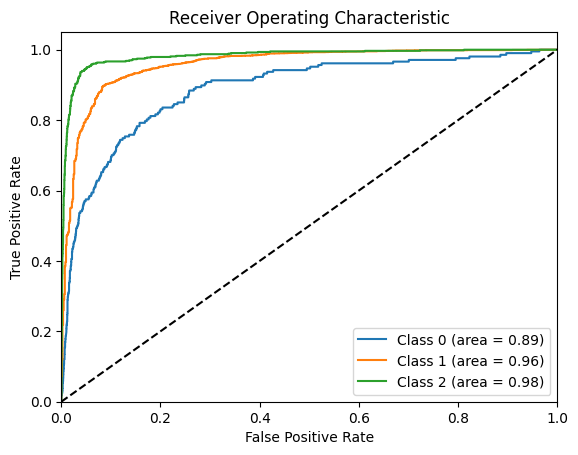

Accuracy: 0.91
F1-score: 0.91
Recall: 0.91
Precision: 0.91
Confusion Matrix:
[[  96   99   12]
 [  83 2734   63]
 [  17   58  556]]


In [5]:
# Evaluation on test set
print("Running Test...")

model.eval()
test_accuracy = 0
nb_test_steps = 0
test_preds = []
test_labels = []

for batch in tqdm(test_dataloader, desc="Testing"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    test_preds.extend(logits)
    test_labels.extend(label_ids)

# Calculate metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

test_pred_labels = np.argmax(test_preds, axis=1)

accuracy = accuracy_score(test_labels, test_pred_labels)
f1 = f1_score(test_labels, test_pred_labels, average='weighted')
recall = recall_score(test_labels, test_pred_labels, average='weighted')
precision = precision_score(test_labels, test_pred_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, test_pred_labels)

# ROC-AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print("Confusion Matrix:")
print(conf_matrix)